##Overview
This notebook is a variation on the 2nd notebook in the YouTube recommendation simulation applied to the MovieLens 1M dataset. 
In this notebook, the model is trained where the dot product of the genre prediction and the movie genre vector are added to the previous dot product.

###Hyperparameters
Since there can be an optimal relative weight to each component in the dot product, we optimize over this weight as a hyperparameter in the range: [0.5,1,2,4,8,16]

###Experiments
The best model is found to be with weight = 1.\
We run this model with high resolution evaluation and plot the results.

###Results
We find that the best model results are very close, but do not improve over the evaluation of the basic model.

**Imports and administration**

In [1]:
# basic
from google.colab import runtime
import os 
import sys
import math
from time import time
import zipfile
import requests
import pickle
import gdown
!pip install --upgrade --no-cache-dir gdown

# general
import warnings
import numpy as np
import pandas as pd
# !pip install scikit-learn
# from sklearn.neighbors import LSHForest
# from sklearn import neighbors.LSHForest
# !apt install libomp-dev
# !python -m pip install --upgrade faiss faiss-gpu
# !pip install faiss-gpu
# import faiss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import average_precision_score

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# notebook
from IPython.display import display, HTML
from tqdm import tqdm
import copy


# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda', index=0)

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


**Loading the datasets**

In [5]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/train_10_markov'
# with open(path , 'rb') as f:
#   (train, test, val, df_items, n_items, max_watches, num_neg_samples) = pickle.load(f)
#   print('loaded training')

loaded training


In [ ]:
url = "https://drive.google.com/file/d/1--hw470oR3_YtvWER6J9la1WO8b7bEur/view?usp=sharing"
datasets_path = 'train_10_markov'
gdown.download(url, datasets_path, quiet=False,fuzzy=True)
# datasets_path = './drive/My Drive/Colab Notebooks/recsys_final_project/train_10_markov'
with open(datasets_path , 'rb') as f:
  (train, test, val, df_items, n_items, max_watches, num_neg_samples) = pickle.load(f)
  print('loaded training')

Downloading...
From: https://drive.google.com/uc?id=1--hw470oR3_YtvWER6J9la1WO8b7bEur
To: /content/train_10_markov
100%|██████████| 448M/448M [00:02<00:00, 178MB/s]


loaded training


In [6]:
n_users = 6040

**preparing genres for all movie indices**

In [59]:
movie_genres = np.zeros((n_items, 18))
movie_ids = df_items['movie id'].to_list()
for movie_idx in range(n_items):
  if movie_idx in movie_ids:
    genre_vector = df_items.loc[df_items['movie id'] == movie_idx]['genres features'].values[0]
    vector_norm = np.sqrt((genre_vector**2).sum())
    movie_genres[movie_idx,:] = genre_vector/vector_norm #Normalized vector size!

In [60]:
movie_genres_torch = torch.from_numpy(movie_genres).to(device)

In [61]:
class Candidates(torch.nn.Module):
    def __init__(self, config):
        super(Candidates, self).__init__()

        self.num_items = config['num_items']
        self.n_neg_samples = config['n_neg_samples']
        self.max_watches = config['max_watches']
        self.latent_dim = config['latent_dim']
        self.features_dim = config['features_dim']
        self.layers = config['layers']
        self.trans_weight = config['trans_weight']

        self.embed_items = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim) #log 4000 ~12
        self.embed_occ = torch.nn.Embedding(num_embeddings=21, embedding_dim=5) # 21 occupations log~5
        self.embed_age = torch.nn.Embedding(num_embeddings=7, embedding_dim=3) # 7 occupations log~3

        self.fc_layers = torch.nn.ModuleList()
        self.fc_layers.append(torch.nn.Linear(self.features_dim, self.layers[0])) #linking features to MLP
        if len(self.layers) > 1:
          for (in_size, out_size) in zip(self.layers[:-1], self.layers[1:]):
              self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        
        # self.LSHIndex = LSHIndex()
        self.N_candidates = config['N_candidates']
        self.knn = KNeighborsClassifier(n_neighbors=self.N_candidates) #initiating the KNN model with maximal N_candidates

    def forward(self, features, mode):
        # previous watches embedding and averaging
        # We must take into account the possible padding with 0's of the user history
        n = self.max_watches
        previous_watches = features[:, :n].int()
        mask = torch.unsqueeze((previous_watches > 0),2)
        embedded_items = self.embed_items(previous_watches)
        sum = mask.sum(dim=1)
        sum[sum == 0] = 1 #so we don't divide by 0 and get nan (even though overwritten)
        embedded_items_mean = (embedded_items*mask).sum(dim=1)/sum
        n_indices = torch.count_nonzero(previous_watches, dim=1)
        embedded_items_mean[(n_indices == 0)] = torch.zeros(self.latent_dim).to(device)

        # other embeddings
        user_age = features[:, n].int()
        emb_age = self.embed_age(user_age)
        user_occupation = features[:, n+1].int()
        emb_occ = self.embed_occ(user_occupation)
        
        # other features
        other_features = features[:, n+2:n+5]

        # predicted genres
        predicted_genres = features[:, n+5:n+23]
        # predicted_genres = self.trans_weight * features[:, n+5:n+23]
        
        # all
        vector = torch.hstack((embedded_items_mean, emb_age, emb_occ, other_features)).to(torch.float32)

        for idx, _ in enumerate(range(len(self.fc_layers)-1)):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
        vector = self.fc_layers[-1](vector) #last layer without RELU

        # stacking vector rep and genres
        vector = torch.hstack((vector, predicted_genres)).to(torch.float32)

        if mode == 'training':
          item_id_label = features[:, -self.n_neg_samples-1].int()
          negative_samples = features[:, -self.n_neg_samples:].int() #negative samples are precalculated

          sample_indices = torch.hstack([torch.unsqueeze(item_id_label, 1), negative_samples])
          sample_embeddings = self.embed_items(sample_indices)
          #make vector of genres from sample indices (from df_items)
          genres_by_idx = self.trans_weight * movie_genres_torch[sample_indices.long(),:]
          #concatenate to embeddings for new representation
          embeddings_and_genres = torch.cat((sample_embeddings, genres_by_idx), dim = 2).to(torch.float32)
          dot_products = torch.matmul(embeddings_and_genres, torch.unsqueeze(vector, dim = 2))
          return dot_products.squeeze()
    
        elif mode == 'serving':
          # candidates = self.lshf.kneighbors(vector, n_neighbors=self.N_candidates, return_distance=False)
          # candidates = self.LSHIndex.query(vector, k = self.N_candidates)
          candidates = self.knn.kneighbors(vector.detach().cpu().numpy(), return_distance=False)
          return candidates #only indices

In [85]:
class Training(object):

  def __init__(self, model, config):
    self.config = config
    self.model = model.to(self.config['device'])
    self.n_neg_samples = config['n_neg_samples']
    self.labels = torch.hstack((torch.tensor(1), torch.zeros(self.n_neg_samples))).repeat(config['batch_size'], 1).to(device)
    #importance weights with ratio of ~3000/100 = 30
    self.importance_weights = torch.hstack((torch.tensor(1), 30*torch.ones(self.n_neg_samples))).to(device)
    self.optimizer = config['optimizer_type'](model.parameters(), **config['optimizer_parameter'])
    self.criterion = config['criterion'](weight = self.importance_weights) #here we add importance weights to the loss function
    self.dl_train = DataLoader(train, batch_size=config['batch_size'], shuffle=True) # create dataloader with given batch size
    self.dl_val = DataLoader(val, batch_size=config['batch_size'], shuffle=False) # create dataloader with given batch size
    self.knn_labels = np.ones(self.model.num_items)
    self.AP_labels = torch.tensor([1, 0]).repeat(1, n_users).squeeze()

  def train(self):
    self.train_loss_history = []
    self.eval_loss_history = []
    self.eval_map_history = []
    self.eval_HR100_history = []
    self.eval_HR200_history = []
    self.eval_MRR100_history = []
    self.eval_MRR200_history = []
    self.eval_NDCG100_history = []
    self.eval_NDCG200_history = []

    epochs_without_improvement = 0
    best_HR = None 
    train_start = time()
    for epoch in range(self.config['n_epochs']):
      self.train_epoch() #train
      self.train_loss_history.append(self.epoch_train_loss/len(self.dl_train))
      # extract all embeddings
      all_embeddings = self.model.embed_items(torch.arange(0, n_items).to(device)).detach().cpu().numpy()
      # Here we concatenate the genres for full representation to insert the KNN model
      embeddings_plus_genres = np.hstack((all_embeddings, self.model.trans_weight*movie_genres))
      self.model.knn.fit(embeddings_plus_genres, self.knn_labels)
      # self.model.LSHIndex.build(all_embeddings)
      # self.model.lshf.kneighbors.fit(all_embeddings)
      if epoch%1 == 0:
      # if epoch%10 == 0:
        self.evaluate_epoch(self.dl_val) #evaluate
        # aggregate metrics: note len(val) = len(test)
        self.eval_loss_history.append(self.epoch_eval_loss/len(self.dl_val))
        average_precision = average_precision_score(self.AP_labels, self.epoch_pred)
        self.eval_map_history.append(average_precision)
        self.eval_HR100_history.append(self.epoch_HR100/len(val))
        self.eval_HR200_history.append(self.epoch_HR200/len(val))
        self.eval_MRR100_history.append(self.epoch_MRR100/len(val))
        self.eval_MRR200_history.append(self.epoch_MRR200/len(val))
        self.eval_NDCG100_history.append(self.epoch_NDCG100/len(val))
        self.eval_NDCG200_history.append(self.epoch_NDCG200/len(val))
        print(f'epoch {epoch}: loss = {self.train_loss_history[-1]}, HR@200 = {self.eval_HR200_history[-1]}, AP = {self.eval_map_history[-1]}')
        # print(f'epoch {epoch}: loss = {self.train_loss_history[-1]}, HR@200 = {self.eval_HR200_history[-1]}')
        #check for early stopping
        if not best_HR or self.eval_HR200_history[-1] > best_HR:
          best_HR = self.eval_HR200_history[-1]
          # best_MRR200 = self.eval_MRR200_history[-1]
          # best_NDCG200 = self.eval_NDCG200_history[-1]
          # best_loss = self.eval_loss_history[-1]
          epochs_without_improvement = 0
          #print ("Achieved lower validation loss, save model at epoch number {} ".format(epoch + 1) )
          best_model = copy.deepcopy(self.model.state_dict())
        else:
          epochs_without_improvement += 1

        if epochs_without_improvement == self.config['early_stopping']:
          if self.config['verbose']:
              print('\nEarly stoping after {} epochs. validation loss did not imporve for more than {} epcochs'.format(epoch, self.config['early_stopping']))
          break
    self.training_time = time() - train_start

    # load best model and best performance
    self.model.load_state_dict(best_model)
    if self.config['verbose']:
        print('\nFinished Training:')
        print('Best metrics are:')
        print(f'Hit Ratio eval = {best_HR}')
    
  def train_epoch(self):
    self.epoch_train_loss   = 0
    self.model.train() # train mode
    for batch in tqdm(self.dl_train, disable=(not self.config['verbose'])):
      self.train_batch(batch)

  def train_batch(self, batch):
     
    batch = batch.to(device)  
    pred = self.model(batch, mode = 'training')
    labels = self.labels
    if pred.shape[0] < self.config['batch_size']:
      labels = torch.hstack((torch.tensor(1), torch.zeros(self.n_neg_samples))).repeat(pred.shape[0], 1).to(device)
    loss = self.criterion(pred, labels)
              
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()               
    self.epoch_train_loss += loss.item()

  def evaluate_epoch(self, dl_eval):
    self.epoch_eval_loss = 0
    self.epoch_pred = torch.empty(0) #Aggregated for AP calculation
    self.epoch_HR100 = 0
    self.epoch_HR200 = 0
    self.epoch_MRR100 = 0
    self.epoch_MRR200 = 0
    self.epoch_NDCG100 = 0
    self.epoch_NDCG200 = 0

    self.model.eval() #evaluation mode
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=(not self.config['verbose'])):
        self.eval_batch(batch) # dl_val was built so that one batch is one user


  def eval_batch(self, batch):
    target_items = batch[:, -num_neg_samples-1]
    # Send tensor to GPU    
    batch = batch.to(device)

    #evaluations of candidates retrieval
    candidates_batch = self.model(batch, mode = 'serving') #already returned sorted from high to low
    for candidates, target_item in zip(candidates_batch, target_items):
      self.epoch_HR100 += self.HitRatio(candidates, target_item, 100)
      self.epoch_HR200 += self.HitRatio(candidates, target_item, 200)
      self.epoch_MRR100 += self.MRR(candidates, target_item, 100)
      self.epoch_MRR200 += self.MRR(candidates, target_item, 200)
      self.epoch_NDCG100 += self.NDCG(candidates, target_item, 100)
      self.epoch_NDCG200 += self.NDCG(candidates, target_item, 200)
  
    #AP evaluation using negative samples
    pred = self.model(batch, mode = 'training') # not really training - extracts negative samples prediction for AP calculation
    labels = self.labels
    if pred.shape[0] < self.config['batch_size']:
      labels = torch.hstack((torch.tensor(1), torch.zeros(self.n_neg_samples))).repeat(pred.shape[0], 1).to(device)
    loss = self.criterion(pred, labels)        
    self.epoch_eval_loss += loss.item()

    probabilities = F.softmax(pred.detach().cpu(), dim = 1)
    for prob in probabilities: #concatenating predictions for average precision calculation at the end of the epoch
      self.epoch_pred = torch.hstack((self.epoch_pred, prob[:2])) #first two here (positive and negative)


  def extract_candidates(self, dl_eval):
    self.model.eval() #evaluation mode
    all_candidates = np.empty((0, self.model.N_candidates))
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=(not self.config['verbose'])):
        target_items = batch[:, -num_neg_samples-1]
        # Send tensor to GPU    
        batch = batch.to(device)
        candidates_batch = self.model(batch, mode = 'serving')
        all_candidates = np.vstack([all_candidates, candidates_batch])
        # previous_watches = batch[:, :max_watches].int()
        # for candidates, prev_watches in zip(candidates_batch, previous_watches):
        #   #remove previous watches from candidates, since there are no duplicities in this dataset
        #   candidates = [x for x in candidates if x not in prev_watches]
      return all_candidates

  def HitRatio(self, ranked_items, target_item, k):
    for item in ranked_items[:k]:
      if item == target_item:
        return 1
    return 0

  def MRR(self, ranked_items, target_item, k):
    for i, item in enumerate(ranked_items[:k]):
      if item == target_item:
        return 1/(i + 1)
    return 0


  def NDCG(self, ranked_items, target_item, k):
    for i, item in enumerate(ranked_items[:k]):
      if item == target_item:
        return np.log(2)/np.log(i + 2)
    return 0


In [77]:
results = pd.DataFrame(columns=['transition_weight', 'maximal width', 'Batch Size', 'Learning Rate', 'Topk', 'Metric', 'Score']) #uncomment to run

In [78]:
def add_results(training_model, results_df, transition_weight, max_width, batch_size, lr):

  MAP = average_precision_score(training_model.AP_labels, training_model.epoch_pred)
  # MAP = training_model.eval_map_history[-1]
  hr200 = training_model.epoch_HR200/len(val)
  tr_time = training_model.training_time

  results_df.loc[len(results_df)] = transition_weight, max_width, batch_size, lr, 0, 'MAP', MAP
  results_df.loc[len(results_df)] = transition_weight, max_width, batch_size, lr, 0, 'TIME', tr_time
  results_df.loc[len(results_df)] = transition_weight, max_width, batch_size, lr, 200, 'HR', hr200

In [82]:
batch_size = 50
lr = 0.001
layers = [1024, 512, 256]

transition_weights = [0.5, 1]

for transition_weight in transition_weights:
  torch.manual_seed(42)
  np.random.seed(42) 
  max_width = layers[0]
  Candidates_config = {'num_items': n_items, 'n_neg_samples': num_neg_samples, 'max_watches': max_watches, 'latent_dim': 256, 'features_dim': 267, 'layers':layers, 'trans_weight':transition_weight, 'N_candidates':250}
  model_Candidates = Candidates(Candidates_config)

  training_config = {'n_neg_samples': num_neg_samples, 'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
                'criterion' : torch.nn.CrossEntropyLoss, 'n_epochs' : 51, 'early_stopping' : 8, 'verbose' : True, 'device' : device}

  training_candidates = Training(model_Candidates, training_config)
  training_candidates.train()
  training_candidates.evaluate_epoch(training_candidates.dl_val)
  add_results(training_candidates, results, transition_weight, max_width, batch_size, lr)

100%|██████████| 121/121 [00:58<00:00,  2.08it/s]


epoch 0: loss = 2.8943353349799352, HR@200 = 0.12119205298013246, AP = 0.8970826002695778


100%|██████████| 121/121 [00:53<00:00,  2.25it/s]


epoch 10: loss = 1.3070974991317617, HR@200 = 0.28228476821192056, AP = 0.897680432264996


100%|██████████| 121/121 [00:52<00:00,  2.30it/s]


epoch 20: loss = 0.9467238002142172, HR@200 = 0.34983443708609274, AP = 0.8782350912796241


100%|██████████| 121/121 [00:50<00:00,  2.38it/s]


epoch 30: loss = 0.8028816521167755, HR@200 = 0.38162251655629137, AP = 0.8683824420956574


100%|██████████| 121/121 [00:49<00:00,  2.44it/s]


epoch 40: loss = 0.7428864360712962, HR@200 = 0.4009933774834437, AP = 0.8598592383884359


100%|██████████| 121/121 [00:48<00:00,  2.47it/s]


epoch 50: loss = 0.716802469228968, HR@200 = 0.40480132450331124, AP = 0.8537044577460207

Finished Training:
Best metrics are:
Hit Ratio eval = 0.40480132450331124


100%|██████████| 121/121 [00:57<00:00,  2.11it/s]


epoch 0: loss = 2.816100556329386, HR@200 = 0.123841059602649, AP = 0.8997021445241189


100%|██████████| 121/121 [00:53<00:00,  2.26it/s]


epoch 10: loss = 1.2915230272917557, HR@200 = 0.27880794701986755, AP = 0.9014243656032344


100%|██████████| 121/121 [00:51<00:00,  2.34it/s]


epoch 20: loss = 0.9514206392086105, HR@200 = 0.35529801324503313, AP = 0.8824341007221166


100%|██████████| 121/121 [00:49<00:00,  2.43it/s]


epoch 30: loss = 0.8059471089146193, HR@200 = 0.3922185430463576, AP = 0.8690343850815674


100%|██████████| 121/121 [00:48<00:00,  2.49it/s]


epoch 40: loss = 0.7376064045835804, HR@200 = 0.4052980132450331, AP = 0.8627939544858019


100%|██████████| 121/121 [00:49<00:00,  2.42it/s]


epoch 50: loss = 0.7083230346700312, HR@200 = 0.4240066225165563, AP = 0.8602339987723768

Finished Training:
Best metrics are:
Hit Ratio eval = 0.4240066225165563


100%|██████████| 121/121 [00:49<00:00,  2.44it/s]


In [79]:
batch_size = 50
lr = 0.001
layers = [1024, 512, 256]

transition_weights = [2, 4, 8, 16]
# transition_weights = [2, 16]

for transition_weight in transition_weights:
  torch.manual_seed(42)
  np.random.seed(42) 
  max_width = layers[0]
  Candidates_config = {'num_items': n_items, 'n_neg_samples': num_neg_samples, 'max_watches': max_watches, 'latent_dim': 256, 'features_dim': 267, 'layers':layers, 'trans_weight':transition_weight, 'N_candidates':250}
  model_Candidates = Candidates(Candidates_config)

  training_config = {'n_neg_samples': num_neg_samples, 'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
                'criterion' : torch.nn.CrossEntropyLoss, 'n_epochs' : 51, 'early_stopping' : 8, 'verbose' : True, 'device' : device}

  training_candidates = Training(model_Candidates, training_config)
  training_candidates.train()
  training_candidates.evaluate_epoch(training_candidates.dl_val)
  add_results(training_candidates, results, transition_weight, max_width, batch_size, lr)

100%|██████████| 121/121 [01:03<00:00,  1.91it/s]


epoch 0: loss = 2.658005600733473, HR@200 = 0.13062913907284768, AP = 0.9122942573162047


100%|██████████| 121/121 [00:52<00:00,  2.29it/s]


epoch 10: loss = 1.2310152538614163, HR@200 = 0.2860927152317881, AP = 0.9061955999801976


100%|██████████| 121/121 [00:51<00:00,  2.34it/s]


epoch 20: loss = 0.8999581946911204, HR@200 = 0.3697019867549669, AP = 0.8842780935340254


100%|██████████| 121/121 [00:51<00:00,  2.34it/s]


epoch 30: loss = 0.7640431386005405, HR@200 = 0.39470198675496687, AP = 0.8719671039416143


100%|██████████| 121/121 [00:48<00:00,  2.49it/s]


epoch 40: loss = 0.7071053767539808, HR@200 = 0.41456953642384103, AP = 0.8691025861337718


100%|██████████| 121/121 [00:48<00:00,  2.51it/s]


epoch 50: loss = 0.6720933604874457, HR@200 = 0.4165562913907285, AP = 0.8636770974539563

Finished Training:
Best metrics are:
Hit Ratio eval = 0.4165562913907285


100%|██████████| 121/121 [00:57<00:00,  2.11it/s]


epoch 0: loss = 2.4452002157636037, HR@200 = 0.1357615894039735, AP = 0.9277329947953473


100%|██████████| 121/121 [00:53<00:00,  2.26it/s]


epoch 10: loss = 1.1949528645304655, HR@200 = 0.2846026490066225, AP = 0.9171291832100787


100%|██████████| 121/121 [00:51<00:00,  2.33it/s]


epoch 20: loss = 0.87653303180408, HR@200 = 0.35149006622516554, AP = 0.8938736126942377


100%|██████████| 121/121 [00:49<00:00,  2.43it/s]


epoch 30: loss = 0.7365015686989226, HR@200 = 0.38294701986754964, AP = 0.8814240254852896


100%|██████████| 121/121 [00:49<00:00,  2.43it/s]


epoch 40: loss = 0.6774293708769198, HR@200 = 0.38990066225165565, AP = 0.8726145508171343


100%|██████████| 121/121 [00:51<00:00,  2.34it/s]


epoch 50: loss = 0.6436178094935634, HR@200 = 0.3978476821192053, AP = 0.86609657561013

Finished Training:
Best metrics are:
Hit Ratio eval = 0.3978476821192053


100%|██████████| 121/121 [00:57<00:00,  2.11it/s]


epoch 0: loss = 2.318163108865157, HR@200 = 0.14188741721854303, AP = 0.9361347696739546


100%|██████████| 121/121 [00:53<00:00,  2.26it/s]


epoch 10: loss = 1.1315277212108208, HR@200 = 0.28874172185430463, AP = 0.929362691048696


100%|██████████| 121/121 [00:50<00:00,  2.38it/s]


epoch 20: loss = 0.8114745230148762, HR@200 = 0.3480132450331126, AP = 0.9048468703194794


100%|██████████| 121/121 [00:51<00:00,  2.35it/s]


epoch 30: loss = 0.6727810123478932, HR@200 = 0.370364238410596, AP = 0.8889005560384149


100%|██████████| 121/121 [00:50<00:00,  2.38it/s]


epoch 40: loss = 0.6084462730090646, HR@200 = 0.3675496688741722, AP = 0.882360560968448


100%|██████████| 121/121 [00:50<00:00,  2.40it/s]


epoch 50: loss = 0.5835245567133391, HR@200 = 0.3754966887417219, AP = 0.8709279992865445

Finished Training:
Best metrics are:
Hit Ratio eval = 0.3754966887417219


100%|██████████| 121/121 [00:58<00:00,  2.07it/s]


epoch 0: loss = 2.6749139702675357, HR@200 = 0.14370860927152318, AP = 0.9298847651995696


100%|██████████| 121/121 [00:57<00:00,  2.11it/s]


epoch 10: loss = 1.2042677628036762, HR@200 = 0.23841059602649006, AP = 0.9309827123546074


100%|██████████| 121/121 [00:56<00:00,  2.14it/s]


epoch 20: loss = 0.8180617451593774, HR@200 = 0.28807947019867547, AP = 0.9160517801631423


100%|██████████| 121/121 [00:57<00:00,  2.10it/s]


epoch 30: loss = 0.6610512375264176, HR@200 = 0.3001655629139073, AP = 0.9028732364651371


100%|██████████| 121/121 [00:55<00:00,  2.17it/s]


epoch 40: loss = 0.5954289028322362, HR@200 = 0.31009933774834436, AP = 0.8987544436555321


100%|██████████| 121/121 [00:55<00:00,  2.19it/s]


epoch 50: loss = 0.5557115274771357, HR@200 = 0.3132450331125828, AP = 0.8937720721814315

Finished Training:
Best metrics are:
Hit Ratio eval = 0.3132450331125828


100%|██████████| 121/121 [00:57<00:00,  2.11it/s]


In [84]:
path = './drive/My Drive/Colab Notebooks/recsys_final_candidates_by_trans_weight'
with open(path, 'wb') as f:
  pickle.dump((results), f)

In [83]:
results

,transition_weight,maximal width,Batch Size,Learning Rate,Topk,Metric,Score
0,2,1024,50,0.001,0,MAP,0.863677
1,2,1024,50,0.001,0,TIME,1920.011247
2,2,1024,50,0.001,200,HR,0.416556
3,4,1024,50,0.001,0,MAP,0.866097
4,4,1024,50,0.001,0,TIME,1916.969209
5,4,1024,50,0.001,200,HR,0.397848
6,8,1024,50,0.001,0,MAP,0.870928
7,8,1024,50,0.001,0,TIME,1916.553076
8,8,1024,50,0.001,200,HR,0.375497
9,16,1024,50,0.001,0,MAP,0.893772


###Best model

Running model with weight = 1

In [96]:
dl_test = DataLoader(test, batch_size=50, shuffle=False)

In [95]:
best_results = pd.DataFrame(columns=['transition_weight', 'maximal width', 'Batch Size', 'Learning Rate', 'Topk', 'Metric', 'Score']) #uncomment to run

In [87]:
def add_results(training_model, results_df, transition_weight, max_width, batch_size, lr):

  MAP = average_precision_score(training_model.AP_labels, training_model.epoch_pred)
  loss = training_model.epoch_eval_loss/len(val)
  hr100 = training_model.epoch_HR100/len(val)
  hr200 = training_model.epoch_HR200/len(val)
  mrr100 = training_model.epoch_MRR100/len(val)
  mrr200 = training_model.epoch_MRR200/len(val)
  ndcg100 = training_model.epoch_NDCG100/len(val)
  ndcg200 = training_model.epoch_NDCG200/len(val)
  tr_time = training_model.training_time

  results_df.loc[len(results_df)] = transition_weight, max_width, batch_size, lr, 0, 'LOSS', loss
  results_df.loc[len(results_df)] = transition_weight, max_width, batch_size, lr, 0, 'MAP', MAP
  results_df.loc[len(results_df)] = transition_weight, max_width, batch_size, lr, 0, 'TIME', tr_time
  results_df.loc[len(results_df)] = transition_weight, max_width, batch_size, lr, 100, 'HR' , hr100
  results_df.loc[len(results_df)] = transition_weight, max_width, batch_size, lr, 200, 'HR', hr200
  results_df.loc[len(results_df)] = transition_weight, max_width, batch_size, lr, 100, 'MRR', mrr100
  results_df.loc[len(results_df)] = transition_weight, max_width, batch_size, lr, 200, 'MRR', mrr200
  results_df.loc[len(results_df)] = transition_weight, max_width, batch_size, lr, 100, 'NDCG', ndcg100
  results_df.loc[len(results_df)] = transition_weight, max_width, batch_size, lr, 200, 'NDCG', ndcg200

In [90]:
batch_size = 50
lr = 0.001
layers = [1024, 512, 256]
transition_weight =1

torch.manual_seed(42)
np.random.seed(42) 
max_width = layers[0]
Candidates_config = {'num_items': n_items, 'n_neg_samples': num_neg_samples, 'max_watches': max_watches, 'latent_dim': 256, 'features_dim': 267, 'layers':layers, 'trans_weight':transition_weight, 'N_candidates':250}
model_Candidates = Candidates(Candidates_config)

training_config = {'n_neg_samples': num_neg_samples, 'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
              'criterion' : torch.nn.CrossEntropyLoss, 'n_epochs' : 61, 'early_stopping' : 8, 'verbose' : True, 'device' : device}

training_candidates = Training(model_Candidates, training_config)
training_candidates.train()
training_candidates.evaluate_epoch(training_candidates.dl_val)
add_results(training_candidates, best_results, transition_weight, max_width, batch_size, lr)

100%|██████████| 121/121 [00:59<00:00,  2.03it/s]


epoch 0: loss = 2.816100556329386, HR@200 = 0.123841059602649, AP = 0.8997021445241189


100%|██████████| 121/121 [00:56<00:00,  2.13it/s]


epoch 1: loss = 2.2482581496436076, HR@200 = 0.1509933774834437, AP = 0.9136164103923915


100%|██████████| 121/121 [00:56<00:00,  2.15it/s]


epoch 2: loss = 2.014180658984658, HR@200 = 0.16870860927152317, AP = 0.9174511511358199


100%|██████████| 121/121 [00:57<00:00,  2.10it/s]


epoch 3: loss = 1.8576246683763353, HR@200 = 0.1827814569536424, AP = 0.9173106352792453


100%|██████████| 121/121 [00:55<00:00,  2.17it/s]


epoch 4: loss = 1.7375743920834648, HR@200 = 0.20165562913907284, AP = 0.914400879631873


100%|██████████| 121/121 [00:55<00:00,  2.17it/s]


epoch 5: loss = 1.6390636052418228, HR@200 = 0.21307947019867549, AP = 0.9160236054186707


100%|██████████| 121/121 [00:53<00:00,  2.26it/s]


epoch 6: loss = 1.5490381678800709, HR@200 = 0.22698675496688742, AP = 0.9125748041610806


100%|██████████| 121/121 [00:54<00:00,  2.22it/s]


epoch 7: loss = 1.4760723367333413, HR@200 = 0.24304635761589405, AP = 0.9105276127831331


100%|██████████| 121/121 [00:54<00:00,  2.24it/s]


epoch 8: loss = 1.409466441439477, HR@200 = 0.2576158940397351, AP = 0.9091069063480828


100%|██████████| 121/121 [00:52<00:00,  2.29it/s]


epoch 9: loss = 1.3475406735049968, HR@200 = 0.272682119205298, AP = 0.9038399852192692


100%|██████████| 121/121 [00:52<00:00,  2.31it/s]


epoch 10: loss = 1.2961078075877088, HR@200 = 0.27996688741721854, AP = 0.901067795160923


100%|██████████| 121/121 [00:52<00:00,  2.32it/s]


epoch 11: loss = 1.248398705887676, HR@200 = 0.2980132450331126, AP = 0.8970343501155633


100%|██████████| 121/121 [00:52<00:00,  2.31it/s]


epoch 12: loss = 1.1996189401836586, HR@200 = 0.30695364238410594, AP = 0.8963977792664095


100%|██████████| 121/121 [00:52<00:00,  2.31it/s]


epoch 13: loss = 1.1573135220007786, HR@200 = 0.31490066225165564, AP = 0.892626355211587


100%|██████████| 121/121 [00:53<00:00,  2.24it/s]


epoch 14: loss = 1.122065714391454, HR@200 = 0.3251655629139073, AP = 0.8909769034519426


100%|██████████| 121/121 [00:52<00:00,  2.32it/s]


epoch 15: loss = 1.0889366049936275, HR@200 = 0.3339403973509934, AP = 0.888879540845279


100%|██████████| 121/121 [00:51<00:00,  2.33it/s]


epoch 16: loss = 1.0581197571132752, HR@200 = 0.3468543046357616, AP = 0.8878691378442523


100%|██████████| 121/121 [00:53<00:00,  2.27it/s]


epoch 17: loss = 1.0276581510013303, HR@200 = 0.3432119205298013, AP = 0.8854196016770466


100%|██████████| 121/121 [00:51<00:00,  2.36it/s]


epoch 18: loss = 1.0031932921303028, HR@200 = 0.3521523178807947, AP = 0.8831397225530768


100%|██████████| 121/121 [00:50<00:00,  2.41it/s]


epoch 19: loss = 0.9812302387263996, HR@200 = 0.35960264900662253, AP = 0.8848204291505259


100%|██████████| 121/121 [00:51<00:00,  2.35it/s]


epoch 20: loss = 0.953156815780117, HR@200 = 0.3610927152317881, AP = 0.8816561079277472


100%|██████████| 121/121 [00:49<00:00,  2.43it/s]


epoch 21: loss = 0.9352136438108043, HR@200 = 0.37748344370860926, AP = 0.8822471812158614


100%|██████████| 121/121 [00:50<00:00,  2.39it/s]


epoch 22: loss = 0.9169831879659007, HR@200 = 0.3710264900662252, AP = 0.8790486079979611


100%|██████████| 121/121 [00:52<00:00,  2.30it/s]


epoch 23: loss = 0.9018847529881245, HR@200 = 0.3663907284768212, AP = 0.8766890397688875


100%|██████████| 121/121 [00:51<00:00,  2.37it/s]


epoch 24: loss = 0.8830110176361554, HR@200 = 0.37781456953642384, AP = 0.8755395889865585


100%|██████████| 121/121 [00:51<00:00,  2.37it/s]


epoch 25: loss = 0.8657387583954445, HR@200 = 0.37334437086092714, AP = 0.8768232260119364


100%|██████████| 121/121 [00:52<00:00,  2.29it/s]


epoch 26: loss = 0.8559372352078458, HR@200 = 0.38543046357615895, AP = 0.8733890131000289


100%|██████████| 121/121 [00:51<00:00,  2.37it/s]


epoch 27: loss = 0.8403693324362008, HR@200 = 0.37864238410596024, AP = 0.8701387682204027


100%|██████████| 121/121 [00:51<00:00,  2.37it/s]


epoch 28: loss = 0.8333626126093383, HR@200 = 0.38642384105960265, AP = 0.8681831769215979


100%|██████████| 121/121 [00:50<00:00,  2.39it/s]


epoch 29: loss = 0.8236997536155365, HR@200 = 0.3920529801324503, AP = 0.87010945351704


100%|██████████| 121/121 [00:49<00:00,  2.46it/s]


epoch 30: loss = 0.8077376938443508, HR@200 = 0.39619205298013244, AP = 0.8698643309855221


100%|██████████| 121/121 [00:49<00:00,  2.45it/s]


epoch 31: loss = 0.801254705921901, HR@200 = 0.396523178807947, AP = 0.8695311151160745


100%|██████████| 121/121 [00:49<00:00,  2.43it/s]


epoch 32: loss = 0.7935419815647977, HR@200 = 0.39486754966887416, AP = 0.8680913497675492


100%|██████████| 121/121 [00:50<00:00,  2.40it/s]


epoch 33: loss = 0.7858702681872327, HR@200 = 0.4059602649006622, AP = 0.8692332736069787


100%|██████████| 121/121 [00:51<00:00,  2.37it/s]


epoch 34: loss = 0.7776122118266213, HR@200 = 0.40033112582781455, AP = 0.8680358093576794


100%|██████████| 121/121 [00:50<00:00,  2.41it/s]


epoch 35: loss = 0.7714131808401832, HR@200 = 0.405794701986755, AP = 0.8665466566987496


100%|██████████| 121/121 [00:50<00:00,  2.41it/s]


epoch 36: loss = 0.7664423425108293, HR@200 = 0.40298013245033115, AP = 0.8642253953923487


100%|██████████| 121/121 [00:47<00:00,  2.55it/s]


epoch 37: loss = 0.7588791974974389, HR@200 = 0.40463576158940395, AP = 0.8648092290572369


100%|██████████| 121/121 [00:49<00:00,  2.46it/s]


epoch 38: loss = 0.7527299493575925, HR@200 = 0.4100993377483444, AP = 0.865102958736669


100%|██████████| 121/121 [00:50<00:00,  2.41it/s]


epoch 39: loss = 0.7475188551359618, HR@200 = 0.40794701986754967, AP = 0.8635830602443341


100%|██████████| 121/121 [00:52<00:00,  2.33it/s]


epoch 40: loss = 0.7471774313327493, HR@200 = 0.40413907284768213, AP = 0.8657719000539281


100%|██████████| 121/121 [00:49<00:00,  2.44it/s]


epoch 41: loss = 0.7399251183704627, HR@200 = 0.4062913907284768, AP = 0.8626386483357679


100%|██████████| 121/121 [00:49<00:00,  2.46it/s]


epoch 42: loss = 0.7363806743914916, HR@200 = 0.4096026490066225, AP = 0.8617633603070817


100%|██████████| 121/121 [00:50<00:00,  2.39it/s]


epoch 43: loss = 0.7343091379740084, HR@200 = 0.4099337748344371, AP = 0.8618775411611987


100%|██████████| 121/121 [00:49<00:00,  2.44it/s]


epoch 44: loss = 0.7315122107845663, HR@200 = 0.41357615894039734, AP = 0.8630731520895507


100%|██████████| 121/121 [00:50<00:00,  2.39it/s]


epoch 45: loss = 0.7237274631364456, HR@200 = 0.4160596026490066, AP = 0.862722683011335


100%|██████████| 121/121 [00:50<00:00,  2.39it/s]


epoch 46: loss = 0.7232601674952057, HR@200 = 0.41456953642384103, AP = 0.8621142290074766


100%|██████████| 121/121 [00:50<00:00,  2.40it/s]


epoch 47: loss = 0.7210657343835822, HR@200 = 0.41788079470198675, AP = 0.8643376166301077


100%|██████████| 121/121 [00:48<00:00,  2.47it/s]


epoch 48: loss = 0.7161865855388294, HR@200 = 0.4193708609271523, AP = 0.8629402765044547


100%|██████████| 121/121 [00:49<00:00,  2.46it/s]


epoch 49: loss = 0.7121552929226679, HR@200 = 0.4185430463576159, AP = 0.8609338223157834


100%|██████████| 121/121 [00:48<00:00,  2.47it/s]


epoch 50: loss = 0.7173143451749686, HR@200 = 0.41572847682119207, AP = 0.8613871788934441


100%|██████████| 121/121 [00:51<00:00,  2.35it/s]


epoch 51: loss = 0.7090596307870864, HR@200 = 0.4246688741721854, AP = 0.859915088051576


100%|██████████| 121/121 [00:50<00:00,  2.41it/s]


epoch 52: loss = 0.7079230634606635, HR@200 = 0.4183774834437086, AP = 0.8539921737016856


100%|██████████| 121/121 [00:50<00:00,  2.39it/s]


epoch 53: loss = 0.7143472771388509, HR@200 = 0.4200331125827815, AP = 0.8591059536751579


100%|██████████| 121/121 [00:57<00:00,  2.10it/s]


epoch 54: loss = 0.705092276964608, HR@200 = 0.4236754966887417, AP = 0.8554363983712323


100%|██████████| 121/121 [00:49<00:00,  2.45it/s]


epoch 55: loss = 0.6992384359678439, HR@200 = 0.4230132450331126, AP = 0.8536798415068034


100%|██████████| 121/121 [00:48<00:00,  2.47it/s]


epoch 56: loss = 0.6985270175540091, HR@200 = 0.4251655629139073, AP = 0.8580820017173023


100%|██████████| 121/121 [00:50<00:00,  2.41it/s]


epoch 57: loss = 0.7034548562032399, HR@200 = 0.420364238410596, AP = 0.8540573128162113


100%|██████████| 121/121 [00:49<00:00,  2.44it/s]


epoch 58: loss = 0.6958739284475316, HR@200 = 0.42665562913907285, AP = 0.8560474850131455


100%|██████████| 121/121 [00:51<00:00,  2.37it/s]


epoch 59: loss = 0.6977261858030117, HR@200 = 0.43178807947019865, AP = 0.8568040643195891


100%|██████████| 121/121 [00:48<00:00,  2.50it/s]


epoch 60: loss = 0.7007849219261317, HR@200 = 0.428476821192053, AP = 0.8543543872122371

Finished Training:
Best metrics are:
Hit Ratio eval = 0.43178807947019865


100%|██████████| 121/121 [00:49<00:00,  2.43it/s]


In [97]:
training_candidates.evaluate_epoch(dl_test)
add_results(training_candidates, best_results, transition_weight, max_width, batch_size, lr)

100%|██████████| 121/121 [00:50<00:00,  2.40it/s]


In [98]:
best_results #On the test set!!

,transition_weight,maximal width,Batch Size,Learning Rate,Topk,Metric,Score
0,1,1024,50,0.001,0,LOSS,0.272081
1,1,1024,50,0.001,0,MAP,0.842339
2,1,1024,50,0.001,0,TIME,5076.330927
3,1,1024,50,0.001,100,HR,0.279470
4,1,1024,50,0.001,200,HR,0.414238
5,1,1024,50,0.001,100,MRR,0.018638
6,1,1024,50,0.001,200,MRR,0.019596
7,1,1024,50,0.001,100,NDCG,0.063400
8,1,1024,50,0.001,200,NDCG,0.082214


In [99]:
path = './drive/My Drive/Colab Notebooks/recsys_final_candidates_best_results_transitions_weight1'
with open(path, 'wb') as f:
  pickle.dump((best_results), f)

In [93]:
def plot_training_summary(training_model, title):
  with plt.rc_context({'lines.linewidth': 1.5, 'lines.marker' : '.', 'lines.markersize' : 8}):

    epochs = np.arange(len(training_model.train_loss_history)) + 1
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,5))
    ax1.plot(epochs, training_model.train_loss_history, 'r', label = 'train loss')
    # ax1.plot(epochs, training_model.eval_loss_history, 'orange', label = 'eval loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LogLoss')
    ax1.legend()
    ax2.plot(epochs, training_model.eval_HR100_history, 'b', label = 'Hit Ratio @100')
    ax2.plot(epochs, training_model.eval_HR200_history, 'g', label = 'Hit Ratio @200')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Hit Ratio')
    ax2.legend()
    ax3.plot(epochs, training_model.eval_MRR100_history, 'b', label = 'MRR@100')
    ax3.plot(epochs, training_model.eval_MRR200_history, 'g', label = 'MRR@200')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MRR')
    ax3.legend()
    ax4.plot(epochs, training_model.eval_NDCG100_history, 'b', label = 'NDCG@100')
    ax4.plot(epochs, training_model.eval_NDCG200_history, 'g', label = 'NDCG@200')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('NDCG')
    ax4.legend()
    fig.suptitle(title, fontsize = 16)

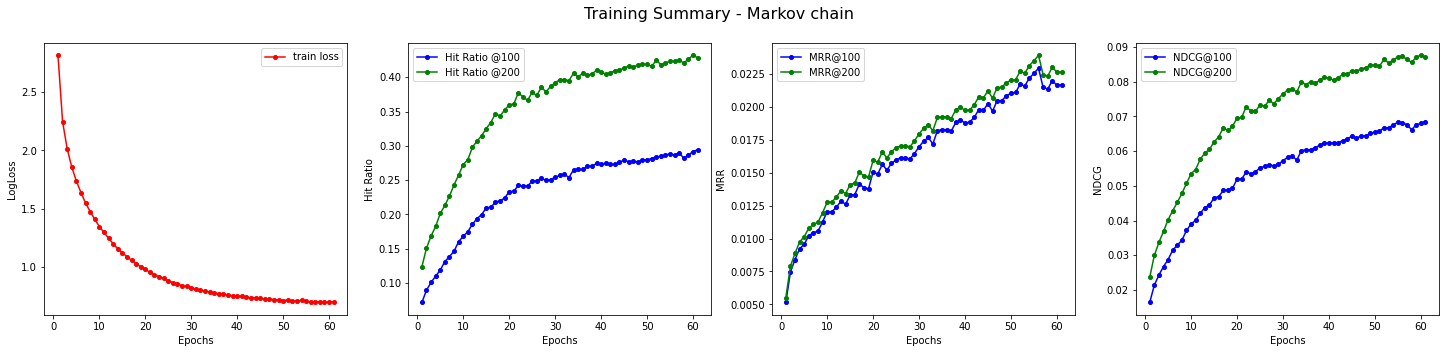

In [100]:
plot_training_summary(training_candidates, 'Training Summary - Markov chain') #without evaluation loss

Conclusion:\
This model gets very close, but does not improve over the basic model.